In [6]:
import wandb
import os
import pandas as pd
import sys
import json

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid", palette="muted")

sys.path.insert(1, "/home/eecs/wooders/experiments/stl/offline")

In [7]:
run = wandb.init()
results_dir = run.use_artifact('ucb-ralf/stl/results:v12', type='dataset').download()
yahoo_train_dir = run.use_artifact('ucb-ralf/stl/yahoo_train_data:v0', type='dataset').download()
yahoo_eval_dir = run.use_artifact('ucb-ralf/stl/yahoo_eval_data:v0', type='dataset').download()
oracle_dir = run.use_artifact('ucb-ralf/stl/oracle:v0', type='dataset').download()

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Downloading large artifact results:v12, 2349.20MB. 11474 files... Done. 0:0:0


In [17]:
artifact_dir = results_dir

# Check Train / Eval Data

In [8]:
key = 3

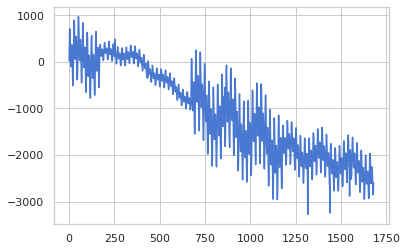

In [9]:
df_train = pd.read_csv(f"{yahoo_train_dir}/{key}.csv")
plt.plot(np.arange(len(df_train)), df_train["value"])

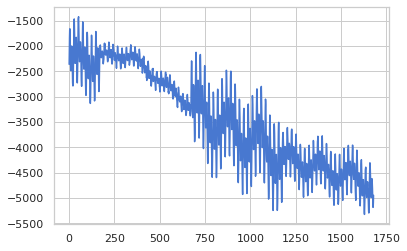

In [10]:
df_eval = pd.read_csv(f"{yahoo_eval_dir}/{key}.csv")
plt.plot(np.arange(len(df_eval)), df_eval["value"])

In [11]:
df_all = pd.concat([df_train["value"], df_eval["value"]], axis = 0)

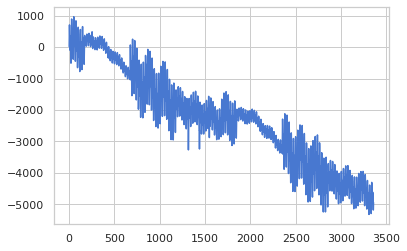

In [12]:
plt.plot(np.arange(len(df_train) + len(df_eval)), df_all)

# Cost Evaluation 

In [21]:
from sktime.performance_metrics.forecasting import mean_squared_scaled_error
def get_loss_per_key(key: int, path, oracle_filename):

    oracle_residual = pd.read_csv(oracle_filename)[
        "pred_residual"
    ]

    df = pd.read_csv(path)
    residual = df["pred_residual"]
    mask = ~np.isnan(residual)
    loss = mean_squared_scaled_error(
        y_true=oracle_residual[mask], y_pred=residual[mask], y_train=df["value"]
    )
    loss = {
        "loss": loss,
        "n_fits": df["model_version"].dropna().nunique(),
    }
    return loss

In [22]:
replica = 1
baseline_results = {}
for key in range(1, 101, 1):
    losses = get_loss_per_key(key, f"{artifact_dir}/plan_eval")
    baseline_results[key] = losses

TypeError: get_loss_per_key() missing 1 required positional argument: 'oracle_filename'

In [ ]:
slide_size = 12
baseline_total_cost = 0
baseline_total_loss = 0
for key in baseline_results.keys(): 
    for loss in baseline_results[key]:
        if loss['slide_size'] == slide_size:
            baseline_total_cost += loss['n_fits']
            baseline_total_loss += loss['loss']
print(baseline_total_cost, baseline_total_loss)

In [20]:
lp_results = {}

for key in range(1, 101, 1):
    oracle_filename = f"{artifact_dir}/plan_eval/oracle_key_A4Benchmark-TS{key}.csv"
    filename = f"{artifact_dir}/lp_plan_eval/{plan}/{key}.csv"
    lp_results[key] = get_loss_per_key(key, filename, oracle_filename)

FileNotFoundError: [Errno 2] No such file or directory: './artifacts/results:v12/plan_eval/oracle_key_A4Benchmark-TS1.csv'

In [ ]:
lp_total_cost = 0
lp_total_loss = 0
for key in lp_results.keys(): 
    lp_total_cost += lp_results[key]['n_fits']
    lp_total_loss += lp_results[key]['loss']
print(lp_total_cost, lp_total_loss)

In [16]:
experiments = [("max_fits_1100", 96), ("max_fits_2100", 48), ("max_fits_4200", 24), ("max_fits_8400", 12)]

graph_results = {"baseline": [], "optimized": [], "cost": []}

replica = 1
for plan, slide_size in experiments:
    print(plan)
    
    baseline_total_cost = 0
    baseline_total_loss = 0
    for key in baseline_results.keys(): 
        for loss in baseline_results[key]:
            if loss['slide_size'] == slide_size:
                baseline_total_cost += loss['n_fits']
                baseline_total_loss += loss['loss']
    print(baseline_total_cost, baseline_total_loss)
    
    for key in range(1, 101, 1):
        oracle_filename = f"{artifact_dir}/plan_eval/oracle_key_A4Benchmark-TS{key}.csv"
        filename = f"{artifact_dir}/lp_plan_eval/{plan}/{key}.csv"
        lp_results[key] = get_loss_per_key(key, filename, oracle_filename)
        
    lp_total_cost = 0
    lp_total_loss = 0
    for key in lp_results.keys(): 
        lp_total_cost += lp_results[key]['n_fits']
        lp_total_loss += lp_results[key]['loss']
    print(lp_total_cost, lp_total_loss)
    
    assert lp_total_cost <= baseline_total_cost
    
    graph_results["baseline"].append(baseline_total_loss)
    graph_results["optimized"].append(lp_total_loss)
    graph_results["cost"].append(baseline_total_cost)


max_fits_1100
0 0


NameError: name 'artifact_dir' is not defined

In [15]:


x = 'Factor'

df = pd.DataFrame({
     x: graph_results["cost"], 
    'baseline': graph_results["baseline"], 
    "optimized": graph_results["optimized"],
})
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = df.melt(id_vars=x).rename(columns=str.title)
seaborn.barplot(x=x, y='Value', hue='Variable', data=tidy, ax=ax1)
seaborn.despine(fig)

ax1.set(xlabel="Cost Budget", ylabel=f'MASE Loss', title='Residual Estimate Loss for Time-Series Decomposition')
#ax1.legend_.remove()
#plt.legend(loc='lower center')

NameError: name 'graph_results' is not defined

In [ ]:
baseline_results[2]

In [144]:
{**graph_results}

{'baseline': [113.47347746568275,
  89.57722060605525,
  81.12720697469311,
  78.42078584418643],
 'optimized': [95.26955983050661,
  81.53832641325205,
  76.2934822322845,
  74.68576266515468],
 'cost': [1100, 2099, 4197, 8375]}

# Plot different numbers of replicas

In [23]:
experiments = [("max_fits_1100", 96), ("max_fits_2100", 48), ("max_fits_4200", 24), ("max_fits_8400", 12)]
replicas = [1, 2]
slides = [1, 6, 12, 18, 24, 48, 96, 168, 192, 336, 672]
graph_results = {"baseline": [], "optimized": [], "cost": []}
prio = "lifo"
replica_results = {}

for slide in slides: 
    replica_results[slide] = []
    for replica in replicas: 
        baseline_plan = f"plan_baseline_{slide}_{prio}"
        
        total_loss = 0
        for key in range(1, 101, 1):
            oracle_filename = f"{oracle_dir}/{key}.csv"
            
            lp_filename = f"{results_dir}/replica_{replica}/{baseline_plan}/{key}.csv"
            
            baseline_filename = f"{results_dir}/replica_{replica}/{baseline_plan}/{key}.csv"
            results = get_loss_per_key(key, baseline_filename, oracle_filename)
            #print(results)
            total_loss += results["loss"]
            
        replica_results[slide].append(total_loss)
        print(baseline_plan, total_loss)
    
replica_results

plan_baseline_1_lifo 172.98378216386888
plan_baseline_1_lifo 112.67935494700063
plan_baseline_6_lifo 180.18115087379635
plan_baseline_6_lifo 115.77955410145175
plan_baseline_12_lifo 184.2670899767375
plan_baseline_12_lifo 120.07497015444703
plan_baseline_18_lifo 190.24309735984917
plan_baseline_18_lifo 122.9708625384093
plan_baseline_24_lifo 196.18648185699215
plan_baseline_24_lifo 128.18398403462876
plan_baseline_48_lifo 225.58043199493562
plan_baseline_48_lifo 144.9251630795228
plan_baseline_96_lifo 320.8503011206009
plan_baseline_96_lifo 189.32209967308512
plan_baseline_168_lifo 431.41793348258363
plan_baseline_168_lifo 293.96569319942313
plan_baseline_192_lifo 544.0725854282231
plan_baseline_192_lifo 339.90741345037276
plan_baseline_336_lifo 949.2024557323098
plan_baseline_336_lifo 705.3804094682863
plan_baseline_672_lifo 1917.3666698011584
plan_baseline_672_lifo 1555.133039236265


{1: [172.98378216386888, 112.67935494700063],
 6: [180.18115087379635, 115.77955410145175],
 12: [184.2670899767375, 120.07497015444703],
 18: [190.24309735984917, 122.9708625384093],
 24: [196.18648185699215, 128.18398403462876],
 48: [225.58043199493562, 144.9251630795228],
 96: [320.8503011206009, 189.32209967308512],
 168: [431.41793348258363, 293.96569319942313],
 192: [544.0725854282231, 339.90741345037276],
 336: [949.2024557323098, 705.3804094682863],
 672: [1917.3666698011584, 1555.133039236265]}

In [24]:
del replica_results[1]

[Text(0.5, 0, 'Num Replicas'),
 Text(0, 0.5, 'MASE Loss'),
 Text(0.5, 1.0, 'Residual Estimate Loss for Time-Series Decomposition')]

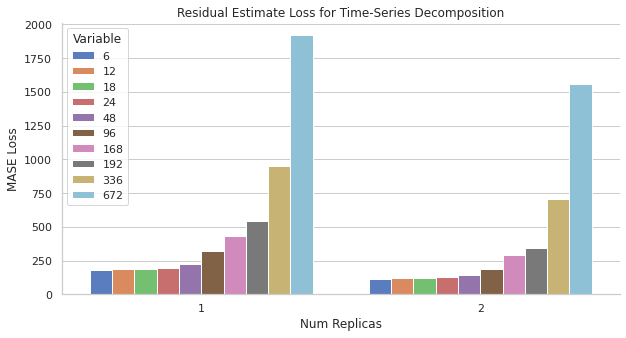

In [25]:
import matplotlib.pyplot as plt
import seaborn

x = 'Factor'

df = pd.DataFrame({
    x: replicas, 
    **replica_results,
})
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = df.melt(id_vars=x).rename(columns=str.title)
seaborn.barplot(x=x, y='Value', hue='Variable', data=tidy, ax=ax1)
seaborn.despine(fig)

ax1.set(xlabel="Num Replicas", ylabel=f'MASE Loss', title='Residual Estimate Loss for Time-Series Decomposition')

In [26]:
experiments = [("max_fits_1100", 96), ("max_fits_2100", 48), ("max_fits_4200", 24), ("max_fits_8400", 12)]
replicas = [1, 2, 4]
slides = [1, 6, 12, 18, 24, 48, 96, 168, 192, 336, 672]
graph_results = {"baseline": [], "optimized": [], "cost": []}

replica_results = {}


 
for plan, slide in experiments: 
    replica_results[plan] = []
    
    for replica in replicas:
        total_loss = 0
        for key in range(1, 101, 1):
            oracle_filename = f"{oracle_dir}/{key}.csv"
            lp_filename = f"{results_dir}/replica_{replica}/{plan}/{key}.csv"
            results = get_loss_per_key(key, lp_filename, oracle_filename)
            total_loss += results["loss"]
            
        replica_results[plan].append(total_loss)
        print(plan, total_loss)
    
replica_results

max_fits_1100 1893.9663657607266
max_fits_1100 133.45026146609104
max_fits_1100 117.59550187337948
max_fits_2100 2875.0872626231935
max_fits_2100 1447.6250864288265
max_fits_2100 99.89538248542472
max_fits_4200 3430.718917641645
max_fits_4200 2591.967671743391
max_fits_4200 95.01342291496671
max_fits_8400 3586.4346343021443
max_fits_8400 3006.052341175111
max_fits_8400 93.57666588051953


{'max_fits_1100': [1893.9663657607266, 133.45026146609104, 117.59550187337948],
 'max_fits_2100': [2875.0872626231935, 1447.6250864288265, 99.89538248542472],
 'max_fits_4200': [3430.718917641645, 2591.967671743391, 95.01342291496671],
 'max_fits_8400': [3586.4346343021443, 3006.052341175111, 93.57666588051953]}

In [245]:
static_results = {1: [213.2200178532724, 150.7256273025718, 133.3349003094353],
 6: [218.75801939773078, 156.0948132080653, 135.81574629721845],
 12: [220.90611494937247, 159.05690147515068, 138.24448802117672],
 18: [229.63341620779627, 163.1813146667572, 140.3471142793597],
 24: [233.91725185369373, 164.71255155633278, 144.22561887879107],
 48: [268.3977607679711, 184.14616983478135, 158.3310894771346],
 96: [348.50466291276604, 229.46322062727472, 189.37872271737845],
 168: [474.50432909190295, 319.6199513026192, 281.5650612571233],
 192: [609.2301332698065, 399.7143084337964, 333.28670707646245],
 336: [908.5841349053487, 728.1723528503993, 650.7431132687982],
 672: [1848.5207568587812, 1612.2188363608043, 1489.8733845259228]}

In [246]:
policy_results = {'max_fits_1100': [1893.9663657607266, 133.45026146609104, 117.59550187337948],
 'max_fits_2100': [2875.0872626231935, 1447.6250864288265, 99.89538248542472],
 'max_fits_4200': [3430.718917641645, 2591.967671743391, 95.01342291496671],
 'max_fits_8400': [3586.4346343021443, 3006.052341175111, 93.57666588051953]}

In [273]:
replicas = [1, 2]
results = {"baseline": [], "policy": []}
for i in range(len(replicas)): 
    
    best_baseline = None
    for key in static_results.keys(): 
        if best_baseline is None or static_results[key][i] <= best_baseline: 
            best_baseline = static_results[key][i]
    results["baseline"].append(best_baseline)
    
    best_baseline = None
    for key in policy_results.keys(): 
        if best_baseline is None or policy_results[key][i] <= best_baseline: 
            best_baseline = policy_results[key][i]
    results["policy"].append(best_baseline)
    
results

{'baseline': [213.2200178532724, 150.7256273025718],
 'policy': [1893.9663657607266, 133.45026146609104]}

[Text(0.5, 0, 'Num Replicas'),
 Text(0, 0.5, 'MASE Loss'),
 Text(0.5, 1.0, 'Residual Estimate Loss for Time-Series Decomposition')]

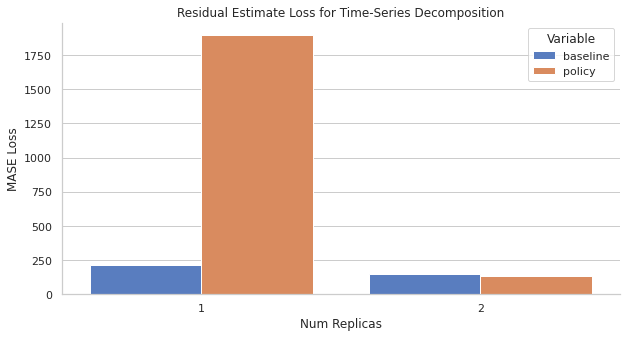

In [274]:
import matplotlib.pyplot as plt
import seaborn

x = 'Factor'

df = pd.DataFrame({
    x: replicas, 
    **results,
})
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = df.melt(id_vars=x).rename(columns=str.title)
seaborn.barplot(x=x, y='Value', hue='Variable', data=tidy, ax=ax1)
seaborn.despine(fig)

ax1.set(xlabel="Num Replicas", ylabel=f'MASE Loss', title='Residual Estimate Loss for Time-Series Decomposition')

ValueError: min() arg is an empty sequence

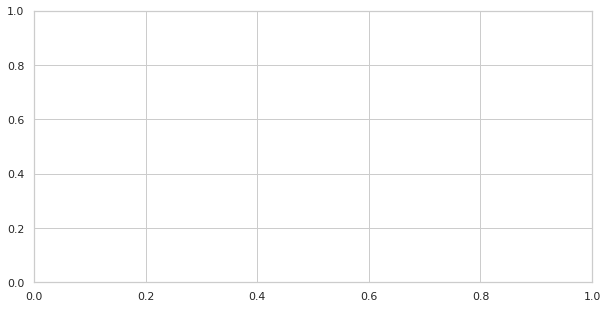

In [277]:
import matplotlib.pyplot as plt
import seaborn

x = 'Factor'

df = pd.DataFrame({
     x: graph_results["cost"], 
    'baseline': graph_results["baseline"], 
    "optimized": graph_results["optimized"],
})
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = df.melt(id_vars=x).rename(columns=str.title)
seaborn.barplot(x=x, y='Value', hue='Variable', data=tidy, ax=ax1)
seaborn.despine(fig)

ax1.set(xlabel="Cost Budget", ylabel=f'MASE Loss', title='Residual Estimate Loss for Time-Series Decomposition')